# Revision

There are a few issues with our current approach:
- While the coefficients of a linear model reflect the contributing factor of a variable, 
  they depend on the scale of the respective variable and are therefore only comparable
  among variables of the same scale.
- Above plots indicate a non-linear relationship between e.g. TV and sales.
- It seems plausible that variables contribute jointly to the sales, as larger marketing 
  campaigns often target several platforms at once.


Let's see if we can improve our model to remedy these deficiencies.

In [1]:
# code starts here
# some of the tools we use
from itertools import product

from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

DEFAULT_COLOR = 'bla'
COLORS = {'TV': '#1b9e77',
          'radio': '#d95f02',
          'newspaper': '#7570b3'}

In [2]:
# util.py
from itertools import product

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_coefficients(coef, names):
    importance = pd.Series(coef, index=names, name='coef')
    fig, ax = plt.subplots()
    importance.plot.bar(ax=ax)
    ax.set_title('Coefficients')

    
def create_model_explorer(df, model):

    def explore_budget_plan(tv_budget=140, radio_budget=20, newspaper_budget=30):
        planned_budged = np.array([[tv_budget, radio_budget, newspaper_budget]])

        sales_pred = model.predict(planned_budged)

        fig, axs = plt.subplots(figsize=(14, 6), ncols=3, sharey=True)
        for xname, ax in zip(xnames, axs):
            df.plot.scatter(ax=ax, x=xname, y=yname, color=COLORS[xname])

        for budget, ax in zip(planned_budged[0], axs):
            ax.scatter(budget, sales_pred, color='k', s=800, marker='+')
            # TODO add vlines and hlines
    
    return explore_budget_plan  
 

def generate_valid_budget_allocations(total_budget):
    
    budget_options = range(0, total_budget + 1, 2)
    
    budget_allocations = []
    for budget_allocation in product(budget_options, budget_options, budget_options):
        if sum(budget_allocation) != total_budget:
            continue
        budget_allocations.append(budget_allocation)
    return np.array(budget_allocations)

# Data Exploration

About the data:
- Advertising and sales data from 200 different markets.
- Sales are in units of 1000.
- Budgets are in units of 1000$.

In [3]:
# read in the data
df = pd.read_csv('http://faculty.marshall.usc.edu/gareth-james/ISL/Advertising.csv', index_col=0)
df

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
...,...,...,...,...
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5


In [4]:
# get a quick overview
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [5]:
# budget where sales are at the minimum
df[df['sales'] == df['sales'].min()]

,TV,radio,newspaper,sales
131,0.7,39.6,8.7,1.6


In [6]:
# budget where sales are at the maximum
df[df['sales'] == df['sales'].max()]

,TV,radio,newspaper,sales
176,276.9,48.9,41.8,27.0


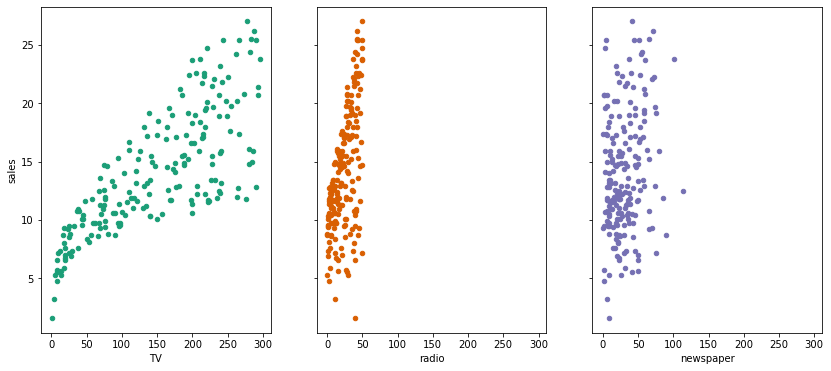

In [7]:
# more often than not, a plot gives much more insight
xnames = ['TV', 'radio', 'newspaper']
yname = 'sales'

fig, axs = plt.subplots(figsize=(14, 6), ncols=3, sharey=True, sharex=True)
for xname, ax in zip(xnames, axs):
    df.plot.scatter(ax=ax, x=xname, y=yname, color=COLORS[xname])

(0.0, 30.0)

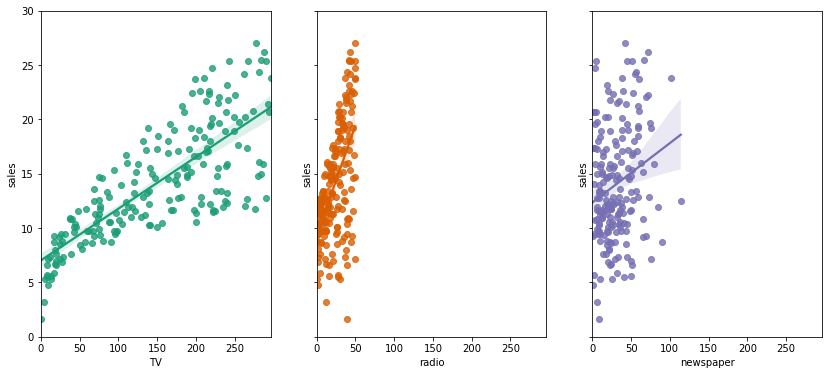

In [8]:
# seems like we have some pretty strong correlations
fig, axs = plt.subplots(figsize=(14, 6), ncols=3, sharey=True, sharex=True)
for xname, ax in zip(xnames, axs):
    sns.regplot(xname, yname, data=df, ax=ax, color=COLORS[xname])
    
axs[0].set_ylim(0, 30)

# Learning from Data

Let's follow this process:
1. Split data into train and test
1. Chose a model and:
  - fit
  - predict
  - evaluate (score, assess, ...)
1. Discuss
1. Iterate...

## Split

In [9]:
from sklearn.model_selection import train_test_split

X = df[xnames]
y = df[yname]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Model

### Choose

In [10]:
from sklearn.linear_model import LinearRegression  # our second machine learning model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

new_model = Pipeline([('scale', StandardScaler()), 
                      ('feature', PolynomialFeatures(degree=3)),
                      ('model', LinearRegression(fit_intercept=False, normalize=False))])

### Fit

In [11]:
model = new_model
model.fit(X_train, y_train)  # that's already it

Pipeline(steps=[('scale', StandardScaler()),
                ('feature', PolynomialFeatures(degree=3)),
                ('model', LinearRegression(fit_intercept=False))])

### Predict

In [12]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_pred[:3]

array([17.0397705 , 22.21401798, 21.69340768])

### Evaluate

#### Score

In [13]:
from sklearn.metrics import r2_score
# https://en.wikipedia.org/wiki/Coefficient_of_determination
# the closer to 1 the better

r2_score(y_test, y_test_pred)  # usually you do not get an R2 that good

0.9893507173596923

In [14]:
# or even easier
model.score(X_test, y_test), model.score(X_train, y_train)

(0.9893507173596923, 0.991622095396409)

#### R2 (Coefficient of Determination)

In the case of linear regression, R2 describes how well the variance in the data can be
described using a linear model.
The close to 1, the better.

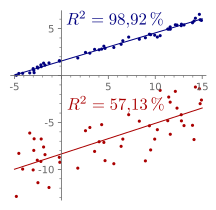

In [15]:
%%svg
https://upload.wikimedia.org/wikipedia/commons/4/4a/R2values.svg

#### Visualize (Actual vs Prediction)

Text(0, 0.5, 'y_test_pred')

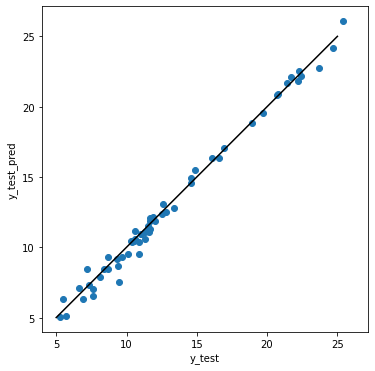

In [16]:
# or plot actual vs. prediction
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, y_test_pred)
ax.plot([5, 25], [5, 25], color='black')
ax.axis('square')
ax.set_xlabel('y_test')
ax.set_ylabel('y_test_pred')

#### Visualize (Residuals = Actual - Pred)

In [17]:
df_test = X_test.assign(sales=y_test, sales_pred=y_test_pred)
df_test['actual-pred'] = df_test['sales'] - df_test['sales_pred']

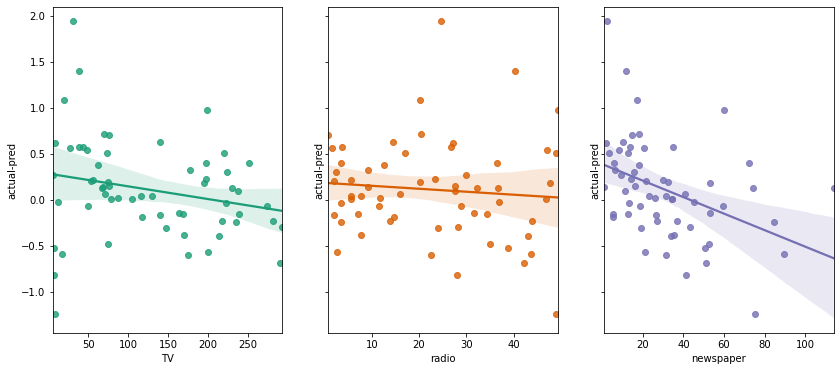

In [18]:
fig, axs = plt.subplots(figsize=(14, 6), ncols=3, sharey=True)

for xname, ax in zip(xnames, axs):
    sns.regplot(xname, 'actual-pred', data=df_test, color=COLORS[xname], ax=ax)

## Discuss

### Q&A: Investment in which channel is most valuable?

We can take a look at the model coefficients. The larger the absolute value of the coefficient, the more important the contributing factor.

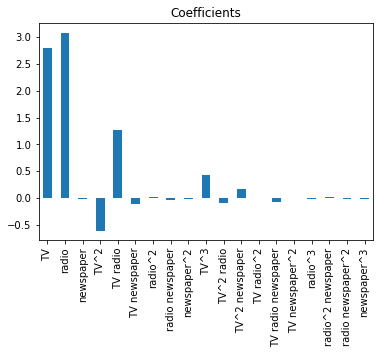

In [19]:
coef = model.named_steps.model.coef_
feature_names = new_model.named_steps.feature.get_feature_names(xnames)
plot_coefficients(coef[1:], feature_names[1:])

In [20]:
explorer = interact(create_model_explorer(df_test, model), 
                    tv_budget=(0, 300), 
                    radio_budget=(0, 50),
                    newspaper_budget=(0, 100))
explorer

interactive(children=(IntSlider(value=140, description='tv_budget', max=300), IntSlider(value=20, description=…

<function __main__.create_model_explorer.<locals>.explore_budget_plan(tv_budget=140, radio_budget=20, newspaper_budget=30)>

### Q&A: How to optimally distribute additional resources?

Procedure:
1. Compute a range of different budget plans.
1. Make a prediction of each budget plan.
1. Assess the result.
1. Pick the plan with the largest increase in sales.

In [21]:
total_extra_budget = 20
extra_budget_allocations = generate_valid_budget_allocations(total_extra_budget)
extra_budget_allocations[:3]

array([[ 0,  0, 20],
       [ 0,  2, 18],
       [ 0,  4, 16]])

#### Status Quo

In [22]:
status_quo = df[xnames + [yname]].mean().to_frame().T
status_quo  # this is where we are on average (budget-wise)

,TV,radio,newspaper,sales
0,147.0425,23.264,30.554,14.0225


#### Possible Budget Plans

In [23]:
current_budget = status_quo[xnames].values
possible_budget_plans = current_budget + extra_budget_allocations
sales_pred = model.predict(possible_budget_plans)

In [24]:
plan = pd.DataFrame(possible_budget_plans, columns=xnames)
plan['sales'] = sales_pred
plan.head(3)

,TV,radio,newspaper,sales
0,147.0425,23.264,50.554,14.738720
1,147.0425,25.264,48.554,15.143540
2,147.0425,27.264,46.554,15.549379


#### Assessment

Compute impact of different budget plans on sales.

In [25]:
absolute_difference = plan - status_quo.values
absolute_difference.sort_values('sales', ascending=False).head(5)

,TV,radio,newspaper,sales
10,0.0,20.0,0.0,4.768021
20,2.0,18.0,0.0,4.475990
9,0.0,18.0,2.0,4.366703
29,4.0,16.0,0.0,4.173580
19,2.0,16.0,2.0,4.068893


In [26]:
relative_difference = (plan - status_quo.values)/status_quo.values
relative_difference.sort_values('sales', ascending=False).head(5).style.format("{:.2%}")

,TV,radio,newspaper,sales
10,0.00%,85.97%,0.00%,34.00%
20,1.36%,77.37%,0.00%,31.92%
9,0.00%,77.37%,6.55%,31.14%
29,2.72%,68.78%,0.00%,29.76%
19,1.36%,68.78%,6.55%,29.02%


#### Decision

Spend the entire additional budget on radio.

# Concluding Remarks

- When *learning from data*, eventual bias is the data is typically learned as well.
- A model can only extrapolate in regions where there is data available.
- The data shows strong correlations. Which? --> Homework.
- We yet have to perform proper model selection, we will do that next time.

---

- Modeling and decision making are two different concepts.

# Follow Up Questions & Exercises

- How come there is a negative value for TV^2, what does it mean? Beforehand we argued that, due to the positive large value, that TV spending is important.
- Using one of the models, describe and interpret the result of spending 0 and an ever increasing advertising budget on sales.
- Compute a [correlation matrix](https://en.wikipedia.org/wiki/Correlation_and_dependence) of the variables.
- Does the scaling (magnitude, size) of the inputs make any difference? Experiment and interpret.